## PSN@PYFFERAPH

In [2]:
import MDAnalysis as mda
import pandas as pd
import matplotlib.pyplot as plt

from pyfferaph import pyfferaph as pf
from pyfferaph import filter_pyff as pyff

import multiprocessing
import numpy as np
import seaborn as sns
import time
import os
from pathlib import Path
import glob
#import ipympl



In [26]:
## Import common data (e.g. pdb and psf files)

nodna = False

if nodna:
    simdir = Path('../../data/00-external_nodna/')
    PDB = simdir / '5Y36_nodna.pdb'
    GRO = simdir / '5Y36_nodna_box.gro'
    trajdir = '../../data/04-prod_nodna/'
    TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology
    XTC = trajdir + 'cas9_prod_pbc_250cut.xtc' # we use only the equilibrated part of the trajectory

else:
    simdir = Path('../../data/00-external/')
    PDB = simdir / '5Y36.pdb'
    TOP = simdir / '5Y36_hydrogen.top'
    GRO = simdir / '5Y36_box.gro'
    trajdir = '../../data/04-prod/'
    TPR = trajdir + 'cas9_prod0_pyff.tpr' # use convert-tpr to delete the solvent from the tpr topology
    XTC = trajdir + 'cas9_prod_pbc_205cut.xtc' # we use only the equilibrated part of the trajectory



# set paths for output
plotpath = "../../plots/"
datapath = "../../data/analysis/pyinteraph/"

if nodna:
    output_name = "prod_nodna_"
else:
    output_name = "prod_"

In [27]:
data_dict = dict(top = TPR, traj = XTC, pdb = GRO) # top = TPR

In [28]:
analysis_dict = dict(system = 'nucleic or protein', start = 0, stop = None, stride = 2)

In [29]:
sb_dict = dict(sb_file = datapath+output_name+'sbridges.dat', # SALT BRIDGES .DAT FILE
               sel_basic = '(resname *LYS and name CE HE* NZ HZ*) or (resname *ARG and name CD HD* NE HE CZ NH* HH1* HH2*)',
               sel_acidic = "(resname *ASP and name CB HB* CG OD*) or (resname *GLU and name CG HG* CD OE*) or (resname DG DG3 DA DA3 DC DC3 DT DT3 RG G RG3 RA A RA3 RC C RC3 RT T RU3 U3 and name P O1P O2P O5' C5' H5'1 H5'2)",
               sb_dist = 4.5,
               cter_sel = 'resid 1368 and resname ASP and name C OC*', 
               nter_sel = 'resid 1 and resname MET and name N H1 H2 H3 CA HA', # beware of PROLINE N-termini (if any): select the N H1 H2 CD HD* CA HA atoms
               histidine_sel = "resname *HIP and name CB HB* CD2 HD2 CG NE2 HE2 ND1 HD1 CE1 HE1") # PROTONATED HISTIDINES (if any)

In [30]:
hc_dict = dict(hc_file = datapath+output_name+'hydrophobic.dat', # HYDROPHOBIC CONTACTS .DAT FILE 
               hydrophobic_sel = "resname GLY ALA ILE VAL LEU PHE MET TRP PRO", 
               backbone_sel = "name N H1 H2 H3 CA HA* C O OC*", hc_cutoff = 5.)

In [31]:
hb_dict = dict(hb_file = datapath+output_name+'hbonds.dat', # HYDROGEN BONDS .DAT FILE 
               tmp_csv = datapath+output_name+'hbonds_temp', # HYDROGEN BONDS TEMPORARY .CSV FILES 
               acceptors = "(protein and name OC* O OG OG1 OD1 OE1 OH OD2 OE2 SD SG) or (protein and resname HIE and name ND1) or (protein and resname HID and name NE2) or (nucleic and name O1P O2P O5' O4' O3' O2') or (nucleic and resname DA* RA* A* and name N3 N1 N7) or (nucleic and resname DG* RG* G* and name N3 O6 N7) or (nucleic and resname DT* and name O2 O4) or (nucleic and resname RU* U* and name O2 O4) or (nucleic and resname RC* DC* C* and name N3 O2)",
               donors = "(protein and not resname PRO and name OG OG1 OH N NE1 ND2 NZ NE NH1 NH2 SG) or (protein and resname GLN HIE HIP and name NE2) or (protein and resname HID HIP and name ND1) or (protein and resname NPRO and name N) or (nucleic and resname *5 and name O5') or (nucleic and resname *3 and name O3') or (nucleic and name O2') or (nucleic and resname DA* RA* A* and name N6) or (nucleic and resname DG* RG* G* and name N1 N2) or (nucleic and resname DT* and name N3) or (nucleic and resname DC* RC* C* and name N4) or (nucleic and resname RU* U* and name N3)",
               #hydrogens = f"{donors} and name *H",
               d_a_dist = 3.5, angle = 140, update_sel = False, ncores = 0 # ncores = 0 stands for 'all available cores'
)

### SALT BRIDGES

In [32]:
sb = pf.SaltBridges(input_dict = data_dict, analysis_dict = analysis_dict, sb_dict = sb_dict)
sb_matrix = sb.run()

Number of groups selected:  1549


<IPython.core.display.Javascript object>


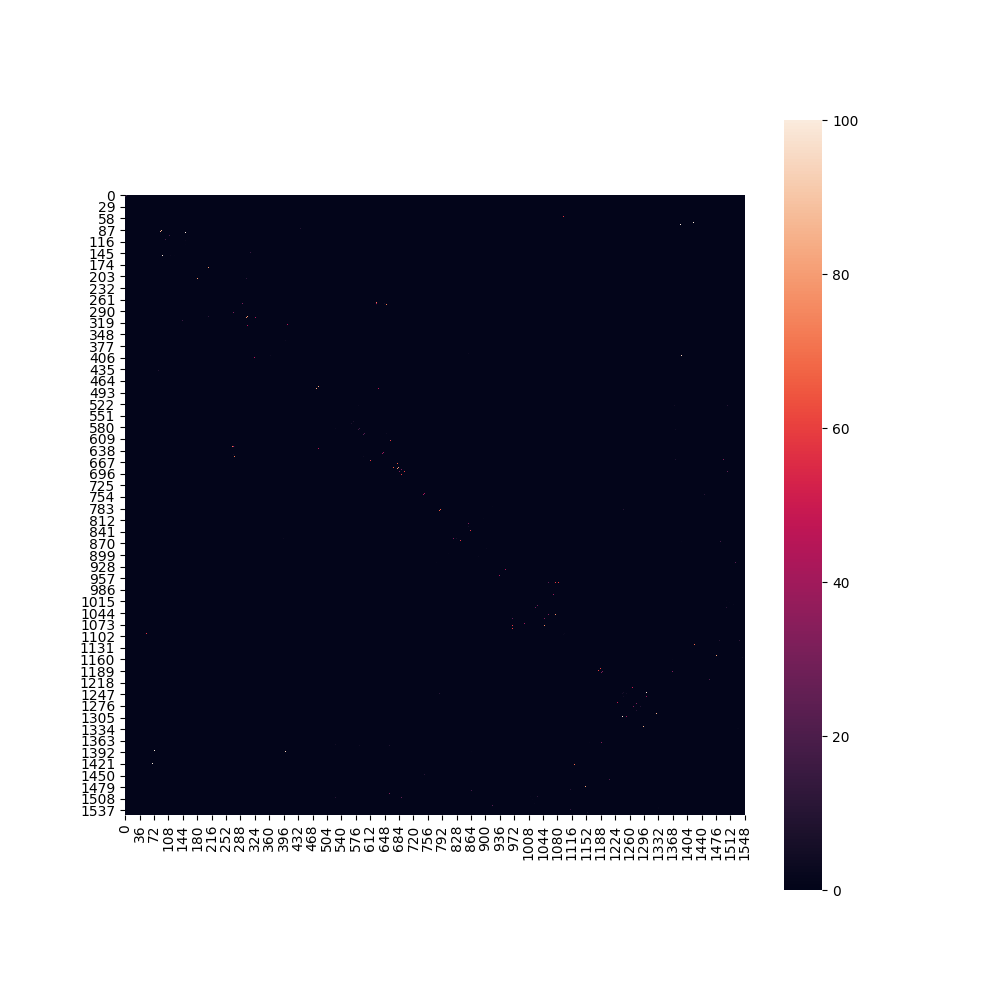

<AxesSubplot:>

In [38]:
canvas, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(sb_matrix, square = True, ax = ax, cbar = True, cmap = 'rocket')

<IPython.core.display.Javascript object>


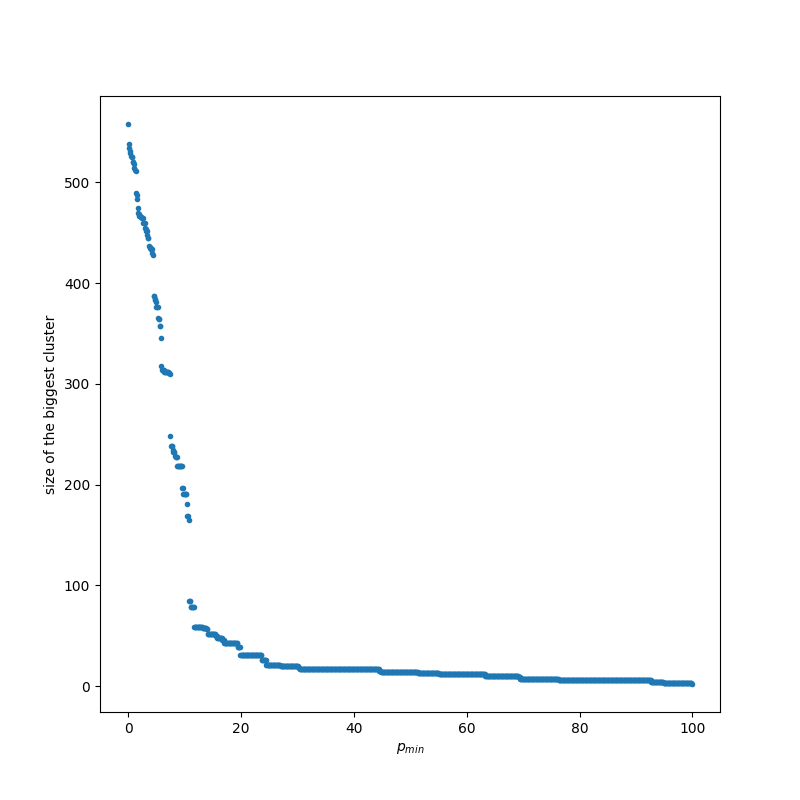

In [39]:
canvas, ax = plt.subplots(figsize = (8, 8))
pyff.cluster_plotter(sb_matrix, plotpath+'sb_subnetworks', stride = 0.1) # SALT BRIDGES sub-networks filename

### HYDROPHOBIC CONTACTS

In [35]:
hc = pf.HydrophobicInteractions(input_dict = data_dict, analysis_dict = analysis_dict, hc_dict = hc_dict)
hc_matrix = hc.run()

Number of groups selected:  1549


<IPython.core.display.Javascript object>


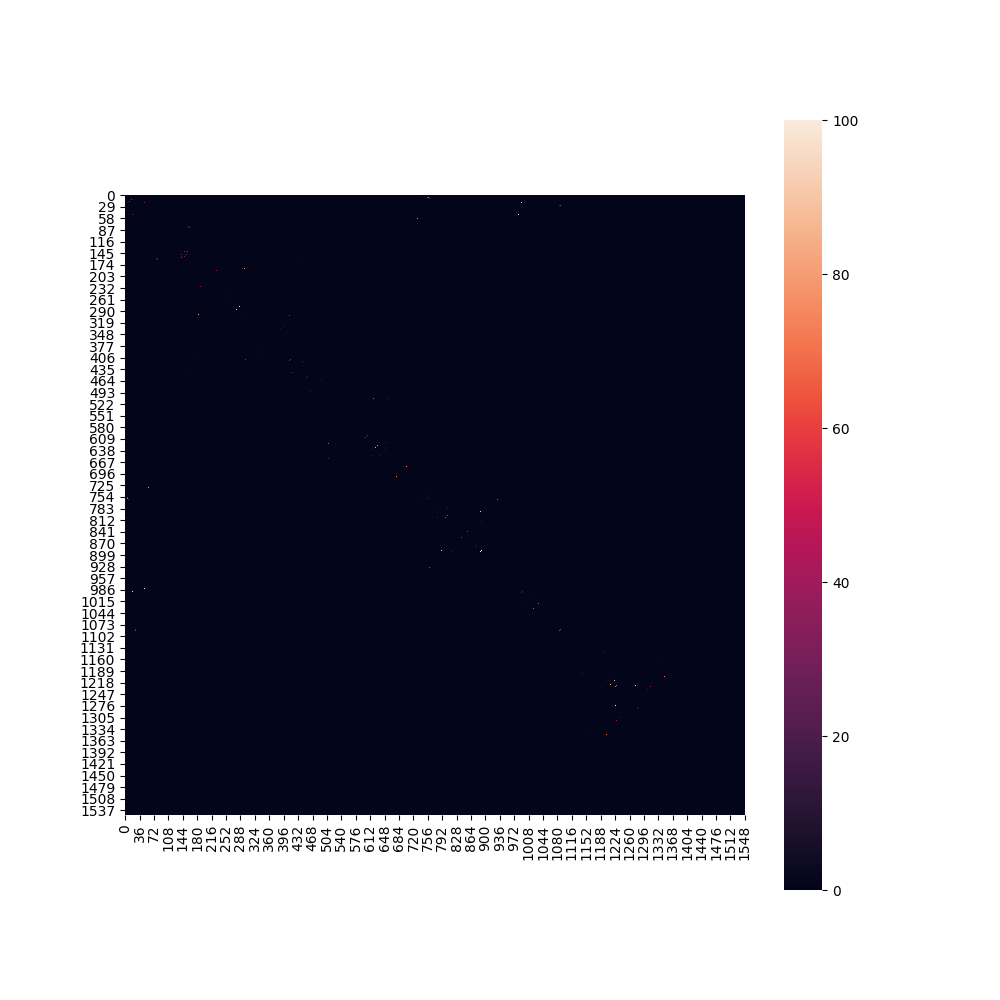

<AxesSubplot:>

In [36]:
canvas, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(hc_matrix, square = True, ax = ax, cbar = True, cmap = 'rocket')

<IPython.core.display.Javascript object>


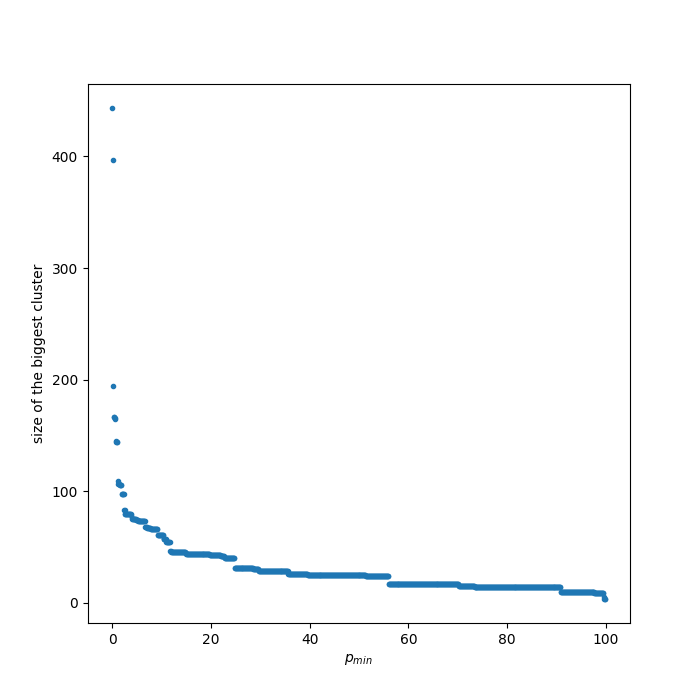

In [37]:
canvas, ax = plt.subplots(figsize = (7, 7))
pyff.cluster_plotter(hc_matrix, plotpath+'hc_subnetworks', stride = 0.1) # HYDROPHOBIC CONTACTS sub-networks

### HYDROGEN BONDS

In [47]:
univ = mda.Universe(data_dict['top'], data_dict['traj'], in_memory = False)

# nr. entries to initialise HB matrix
sel = univ.select_atoms(analysis_dict['system'])
residxs = np.unique(sel.resindices)
nres = len(residxs)

# nr. frames to run multithreads
if analysis_dict['stop'] == None:
    nframes = (univ.trajectory.n_frames - analysis_dict['start']) // analysis_dict['stride']
else:
    nframes = (analysis_dict['stop'] - analysis_dict['start']) // analysis_dict['stride']

In [48]:
pf.HBondInteraction(PDB = data_dict['top'], XTC = data_dict['traj'],
                    donor_sel = hb_dict['donors'], acceptor_sel = hb_dict['acceptors'],
                    nframe = nframes, output_csv = hb_dict['tmp_csv'], 
                    start = analysis_dict['start'], stop = analysis_dict['stop'], stride = analysis_dict['stride'],
                    up_sels = hb_dict['update_sel'], dist = hb_dict['d_a_dist'], angle = hb_dict['angle'],
                    ncores = hb_dict['ncores'])


using all the available cores
Using 4
THe intervals are: [(0, 2825), (2825, 5650), (5650, 8475), (8475, None)]
Pooling with 0 core(s)...
Initialising: ForkPoolWorker-8Initialising: ForkPoolWorker-7Initialising: ForkPoolWorker-5Initialising: ForkPoolWorker-6



ForkPoolWorker-5 doing from 0 to 2825, every 2 frame
ForkPoolWorker-7 doing from 5650 to 8475, every 2 frame
ForkPoolWorker-8 doing from 8475 to None, every 2 frame
ForkPoolWorker-6 doing from 2825 to 5650, every 2 frame
snaso
Creating table: ForkPoolWorker-8
snaso
Creating table: ForkPoolWorker-5
snaso
Creating table: ForkPoolWorker-7
snaso
Creating table: ForkPoolWorker-6


In [16]:
# To use instead of HBondInteraction if that's not working and not giving useful error messages
#pf.serial_hb(PDB = data_dict['top'], XTC = data_dict['traj'],
#                    donor_sel = hb_dict['donors'], acceptor_sel = hb_dict['acceptors'],
#                    output_csv = hb_dict['tmp_csv'], 
#                    start = analysis_dict['start'], stop = analysis_dict['stop'], stride = analysis_dict['stride'],
#                    up_sels = hb_dict['update_sel'], dist = hb_dict['d_a_dist'], angle = hb_dict['angle'])


In [49]:
merged_df = pf.MergingHBDataframe(start = analysis_dict['start'], output_csv = hb_dict['tmp_csv'],
                                  nframe = nframes, stride = analysis_dict['stride'], ncores = hb_dict['ncores'])

hb_matrix = pf.HBMatrix(u = univ, nres = nres, nframes = nframes, hb_df = merged_df, hb_file = hb_dict['hb_file'])

using all the available cores
Using 4


In [50]:
len(hb_matrix)

1549

<IPython.core.display.Javascript object>


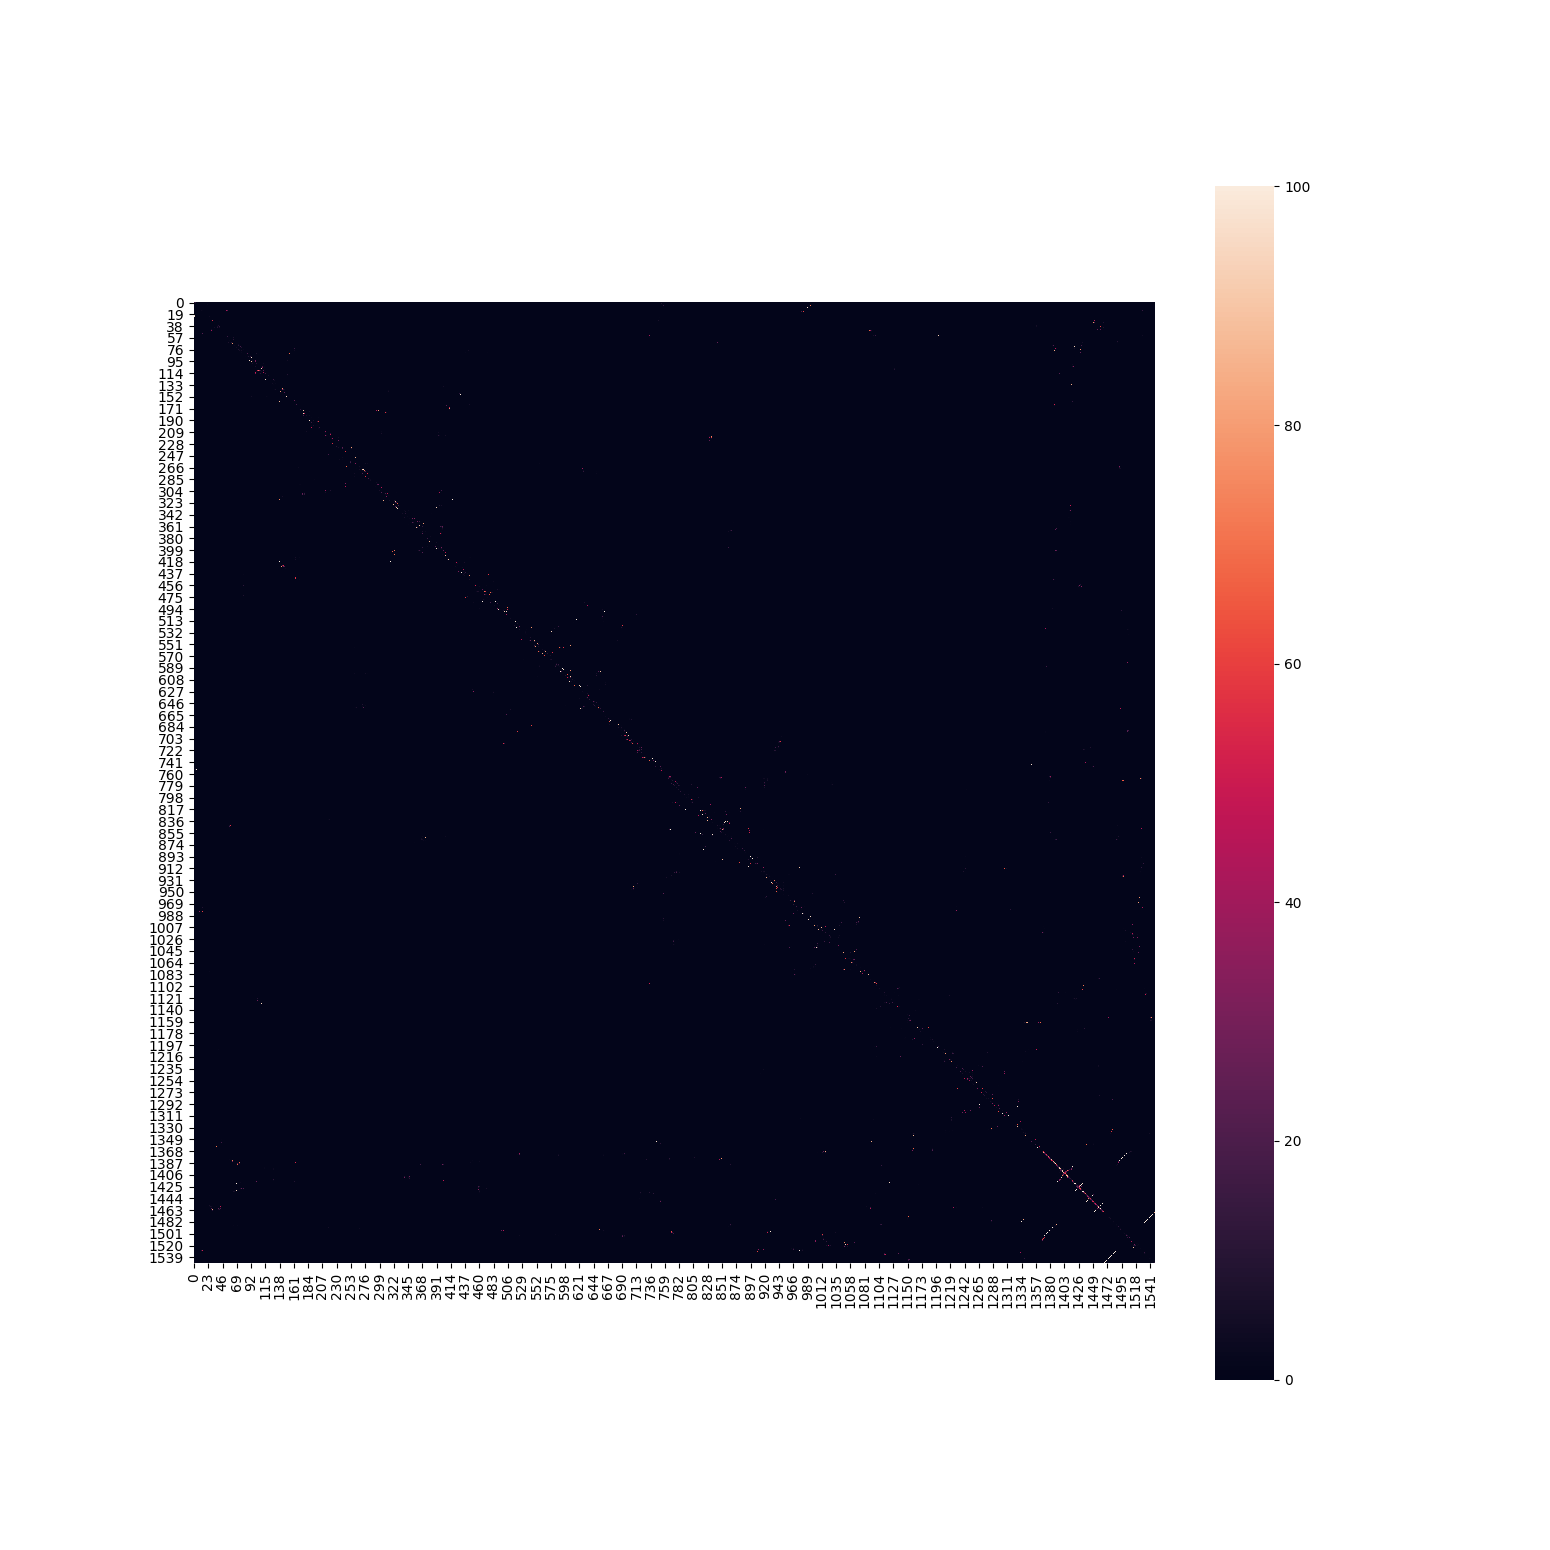

<AxesSubplot:>

In [51]:
canvas, ax = plt.subplots(figsize = (15.5, 15.5))
sns.heatmap(hb_matrix, square = True, ax = ax, cbar = True, cmap = 'rocket')

<IPython.core.display.Javascript object>


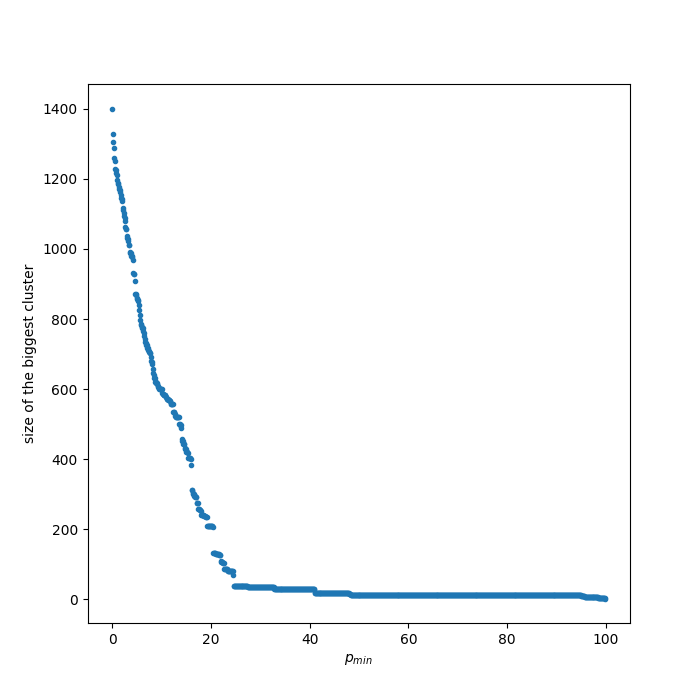

In [52]:
canvas, ax = plt.subplots(figsize = (7, 7))
pyff.cluster_plotter(hb_matrix, plotpath+'hb_subnetworks', stride = 0.1) # HYDROGEN BONDS sub-networks filename

In [53]:
import networkx as nx
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.special import expit

%matplotlib notebook


In [54]:
#hb_matrix = hb_matrix / 100
vals = np.arange(0.1, 100, 0.05)
maxclustsize = []
for val in vals:       
    boolmats = np.array([i>val for i in hb_matrix])
    G = nx.Graph(boolmats)
    #print(len(max(nx.connected_components(G), key=len)))
    maxclustsize.append(len(max(nx.connected_components(G), key=len)))
    #print(maxclustsize)


<IPython.core.display.Javascript object>


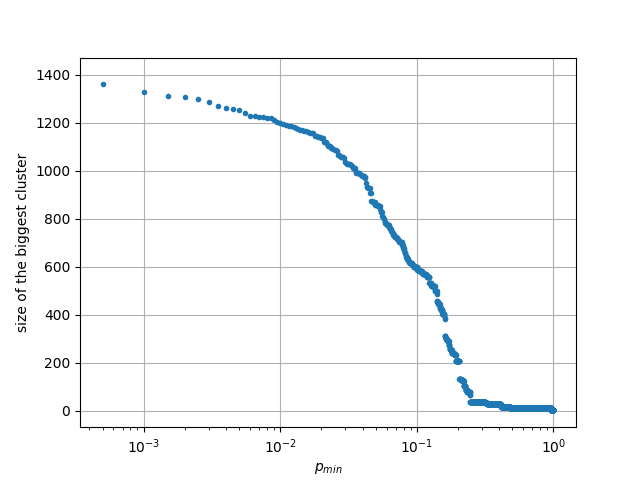

In [55]:
fig = plt.figure()

x = vals / 100
y = maxclustsize
plt.semilogx(x,y, '.')
#plt.title(fig_name)
plt.xlabel('$p_{min}$')
plt.ylabel('size of the biggest cluster')
plt.grid()
plt.show()


In [56]:
output_name = "prod_"
output_name_n = "prod_nodna_"

sb_file = datapath+output_name+'sbridges.dat'
hc_file = datapath+output_name+'hydrophobic.dat'
hb_file = datapath+output_name+'hbonds.dat'

sb_file_n = datapath+output_name_n+'sbridges.dat'
hc_file_n = datapath+output_name_n+'hydrophobic.dat'
hb_file_n = datapath+output_name_n+'hbonds.dat'


In [57]:
sb_matrix = np.loadtxt(sb_file)
hc_matrix = np.loadtxt(hc_file)
hb_matrix = np.loadtxt(hb_file)

reduced_matrix = np.amax([sb_matrix, hc_matrix, hb_matrix], axis=0)
type_matrix = np.argmax([np.zeros(np.shape(sb_matrix)), sb_matrix, hc_matrix, hb_matrix], axis=0)

In [65]:
vals = np.arange(1, 100, 0.05)
maxclustsize = []
for val in vals:       
    boolmats = np.array([i>val for i in reduced_matrix])
    G = nx.Graph(boolmats)
    #print(len(max(nx.connected_components(G), key=len)))
    maxclustsize.append(len(max(nx.connected_components(G), key=len)))
    #print(maxclustsize)


<IPython.core.display.Javascript object>


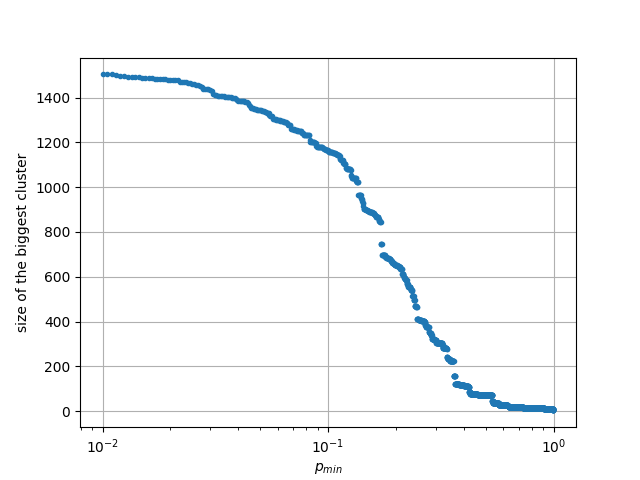

In [68]:
fig = plt.figure()

x = vals / 100
y = maxclustsize
plt.semilogx(x,y, '.')
#plt.title(fig_name)
plt.xlabel('$p_{min}$')
plt.ylabel('size of the biggest cluster')
plt.grid()
plt.show()


In [6]:
c = (a, b)
c

(array([0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1.]))

In [9]:
d = np.array(c)
d

array([array([0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1.])],
      dtype=object)